# Homework 05 - Taming text

## Exercise 1 - Generating word clouds

### Step one - Using the raw corpus

In this part we will use the raw email contents with minimal pre-processing to generate a word cloud using the [word_cloud](https://github.com/amueller/word_cloud) library.

In [1]:
# Imports
%load_ext autoreload

%autoreload 1
    
%aimport helper
import numpy as np
import pandas as pd
from wordcloud import WordCloud as wc
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk import WordNetLemmatizer as wnl
import nltk
import re
import pycountry as pc
from PIL import Image
from os import path
from nltk.sentiment import SentimentIntensityAnalyzer as st
from nltk.stem import WordNetLemmatizer

%matplotlib inline

In [ ]:
# Uncomment and Run to download packages for nltk
nltk.download()

First we load the email data, try to understand it's structure and choose which fields to use.

In [2]:
raw_emails = pd.read_csv('hillary-clinton-emails/Emails.csv')
raw_emails.head()

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\r\nU.S. Department of State\r\nCa...
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\r\nThursday, March 3, 2011 9:45 PM\r\nH: La...",UNCLASSIFIED\r\nU.S. Department of State\r\nCa...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\r\nU.S. Department of State\r\nCa...
3,4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...,F-2015-04841,...,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,NaN,UNCLASSIFIED\r\nU.S. Department of State\r\nCa...
4,5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\r\nFriday, March 1...",B6\r\nUNCLASSIFIED\r\nU.S. Department of State...


It seems that the `ExtractedBodyText` field is what we would like to work with. However there are some missing values. Let's see if there are many of them.

In [3]:
print('Number of emails with null ExtractedBodyText:', raw_emails['ExtractedBodyText'].isnull().sum())
print('Total number of emails:', len(raw_emails))

Number of emails with null ExtractedBodyText: 1203
Total number of emails: 7945


So we will not use this field. We will instead use `RawText` and do some minimal preprocessing on it to remove irrelevant parts.

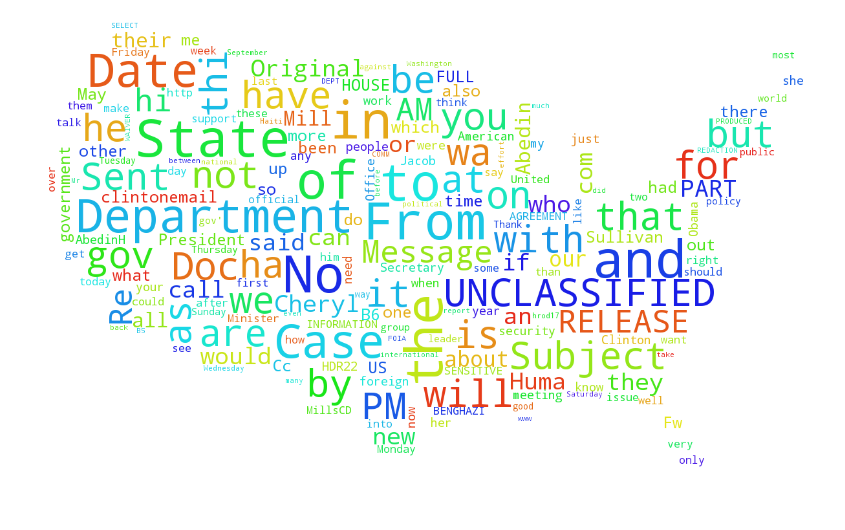

In [6]:
raw_text = raw_emails['RawText']
helper.usa_cloud(raw_text)

That's useful.

### Step two - Text processing pipeline

Let us first define a cutom function that tries to remove the content we do not want to consider for building the word cloud. We want to focus on the email body content so we try to remove
- Email protocol details (sender, recipient, etc.)
- Unclassified status
- U.S. Department of State and other recurrent headers
- Case and document numbers

In [7]:
text = '\n'.join(raw_text.map(helper.preprocess_raw_email)).strip().lower()

Tokenisation

In [8]:
tokenizer = RegexpTokenizer(r'\w+')
basic_tokens = tokenizer.tokenize(text)

Remove punctuations and numbers

In [9]:
# punctuation and numbers to be removed
punctuation = re.compile(r'[_\<\>\@\-\.\?!,":;()|0-9]')
single_letter = re.compile('^([a-z]|[A-Z])$')
# replace punctuation by an empty string
tokens = [punctuation.sub("", word) for word in basic_tokens]  
# replace numbers by an empty string
tokens = [single_letter.sub("", word) for word in tokens]
# filter out the emtpy strings
tokens = list(filter(None, tokens))

Remove stopwords

In [10]:
my_stopwords = stopwords.words('english')+["cc, re, fw, fwd, com, pm"]
filtered_tokens = [ t for t in tokens if t not in my_stopwords]

Lemmatization

In [11]:
lemmatizer = WordNetLemmatizer()
lemmatized_tokens = [ lemmatizer.lemmatize(w) for w in filtered_tokens] 

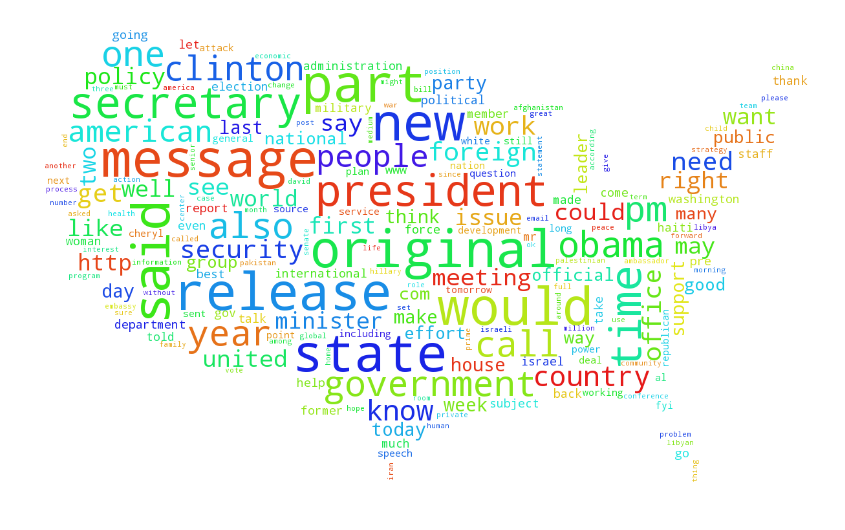

In [13]:
helper.usa_cloud(lemmatized_tokens)

This is more useful than the previous one. However there are still many words that don't have a lot of meaning (like one, would, or could). This could easily be improved by adding stopwords, either manually or finding a better list.

# Exercise 2

Preprocess email headers etc...

In [14]:
preprocessed = []
for x in raw_text:
    preprocessed.append(helper.preprocess_raw_email(x))

Preprocess each email (tokenization, rm stopwords etc...)

In [15]:
dic = {}
i = 0
for em in preprocessed:
    basic_tokens = tokenizer.tokenize(em)
    tokens = [punctuation.sub("", word) for word in basic_tokens]  
    tokens = [single_letter.sub("", word) for word in tokens]  
    tokens = filter(None, tokens)
    filtered_tokens = [ t for t in tokens if t.lower() not in my_stopwords]
    dic[i] = filtered_tokens
    i = i+1

Find which countries are mentionned in each emails

In [16]:
my_index = {}
for (k,v_arr) in dic.items():
    my_index[k] = set()
    for v in v_arr:
        try:
            if(v.lower() == 'uk' or v == 'US'):
                my_index[k].add(pc.countries.lookup(v).name)
            else:
                country = pc.countries.lookup(v)
                if(country.name == v):
                    my_index[k].add(country.name)
        except:
            ;
        

Filter emails without any mention of a country

In [19]:
emails_with_countries = {}
for (k,v) in my_index.items():
    if len(my_index[k])>0:
        emails_with_countries[k] = [cs for cs in v ]
    

Perform sentiment analysis using Vader approach 

In [21]:
vader_analyzer = st()
sentiments = {}
for (k,v_arr) in emails_with_countries.items():
    sentiments[k] = vader_analyzer.polarity_scores(preprocessed[k])  

KeyboardInterrupt: 

Write those values in json, since it take a while to compute them

In [ ]:
helper.write(emails_with_countries, 'emails_with_countries')
helper.write(sentiments, 'sentiments')  

Read from json

In [22]:
emails_with_countries = helper.read('emails_with_countries')
sentiments = helper.read('sentiments')

Create a Dict[Countriy -> Sentiment]

In [23]:
countries_sentiments = {}
for (k,v_arr) in emails_with_countries.items():
    for v in v_arr:
        if(v not in countries_sentiments.keys()):
            countries_sentiments[v] = []
        countries_sentiments[v].append(sentiments[k])
        

Count the number of mention of each country and filter out the ones that appear less than 50 times

In [24]:
counts = {}
for (k, v_arr) in countries_sentiments.items():
    counts[k] = len(v_arr)
df = pd.DataFrame.from_dict(data=counts, orient='index')
df.columns = ['Counts']
df_sorted = df.sort_values(by='Counts')
df_sorted = df_sorted[df_sorted.Counts > 10]

Aggregate all sentiments per country

In [25]:
countries_agg_sentiments = {}
for (k, sent_arr) in countries_sentiments.items():
    size = len(sent_arr)
    cmp = 0
    mean = 0
    for sent in sent_arr:
        cmp = cmp + sent['compound']
    mean = (cmp)/size
    countries_agg_sentiments[k] = {'compound':mean}

Plot the average sentiments per country (which are mentioned more than 30 times)

Range: [-1, 1] (Negative < Neutral < Positive)

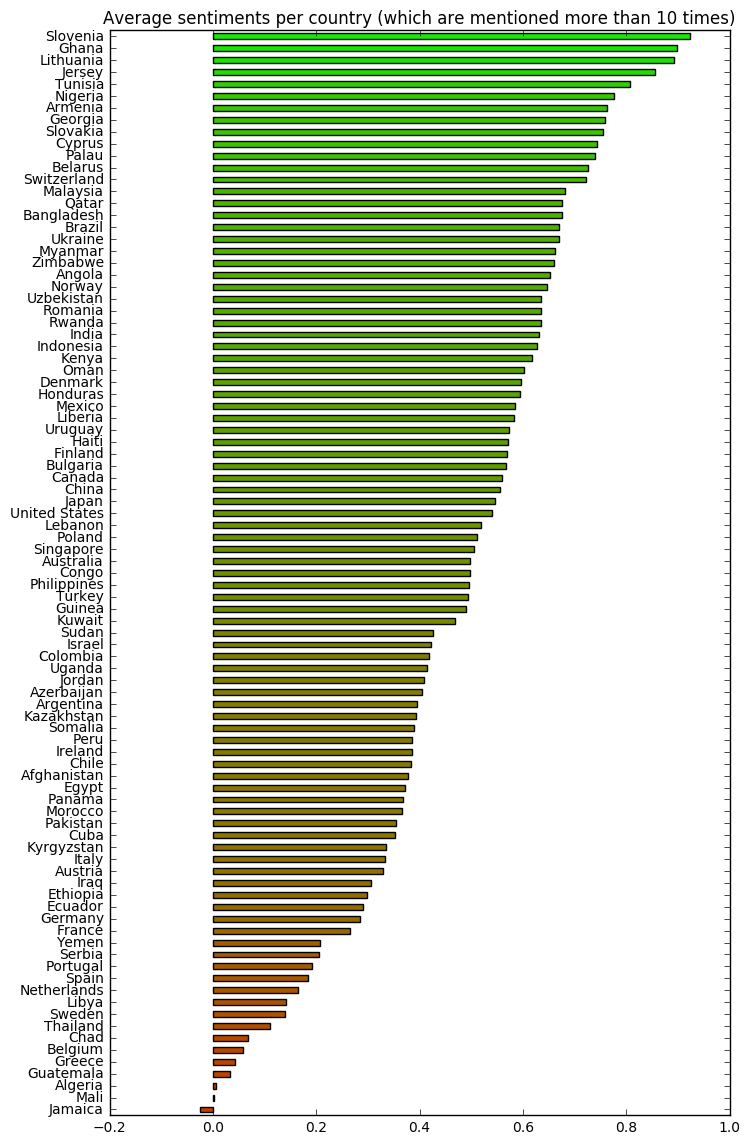

In [26]:
df2 = pd.DataFrame.from_dict(data=countries_agg_sentiments, orient='index')
df2 = df2.join(df_sorted, how='inner').sort_values(by='compound')
plt.figure(figsize=(8,14))
cmap = [(1-(df2['compound'][x]+1)*(df2['compound'][x]+1)/4, (df2['compound'][x]+1)*(df2['compound'][x]+1)/4, 0) for x in range(len(df2['compound']))]
df2['compound'].plot(kind='barh', color=cmap)
plt.title('Average sentiments per country (which are mentioned more than 10 times)')

# Exercise 3

In [28]:
from gensim import corpora, models

C:\Program Files\Anaconda3\lib\site-packages\gensim\utils.py:840: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Program Files\Anaconda3\lib\site-packages\gensim\utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


In [31]:
texts = [lemmatized_tokens]


# Build a dictionary that maps words to integers
dictionary = corpora.Dictionary(texts)
# Now build a corpus that contains the word count for each word of the dictionary for each document
corpus = [dictionary.doc2bow(text) for text in texts]

In [120]:
# Apply LDA model
lda_models = []
for i in [5, 10, 20, 25, 50]:
    lda_models.append(models.LdaModel(corpus, num_topics=i, id2word=dictionary))

Let's check the topics we fin

In [127]:
lda_models[0].show_topics(num_topics=5, formatted=False)

[(0,
  [('original', 0.0058294931795973897),
   ('message', 0.0056481370560966223),
   ('would', 0.0051047616230932829),
   ('state', 0.0043472639144860933),
   ('release', 0.0042012937207986873),
   ('said', 0.0041799156698751122),
   ('secretary', 0.0037691631632956143),
   ('president', 0.0034101770251508019),
   ('time', 0.0033879277752009644),
   ('part', 0.0033442007484847146)]),
 (1,
  [('original', 0.0056052890557254107),
   ('message', 0.0054885813685547971),
   ('said', 0.0054309017901477833),
   ('state', 0.004683955359754818),
   ('part', 0.004602394205566334),
   ('release', 0.0044035550992897543),
   ('government', 0.0042492054873987679),
   ('would', 0.0040138422095539949),
   ('also', 0.0038808444187030176),
   ('president', 0.0036612263454914411)]),
 (2,
  [('state', 0.0072596422129628359),
   ('message', 0.007103165775811264),
   ('would', 0.0061310733848873684),
   ('original', 0.0056846593266379735),
   ('part', 0.0045646901334174114),
   ('secretary', 0.00410638540

In [128]:
lda_models[1].show_topics(num_topics=10, formatted=False)

[(0,
  [('message', 0.0054736350857704282),
   ('said', 0.005441215606644993),
   ('state', 0.0048960818169318972),
   ('original', 0.0046868583815406831),
   ('release', 0.004342224264659124),
   ('part', 0.0040784034387254487),
   ('secretary', 0.0038077215295458512),
   ('new', 0.0036494687892678016),
   ('would', 0.0035512554218940962),
   ('u', 0.0034493877635466182)]),
 (1,
  [('message', 0.0074854836162795259),
   ('original', 0.0072950201124990892),
   ('state', 0.0058620515288688576),
   ('would', 0.0053614199077103167),
   ('release', 0.0043297766776667608),
   ('part', 0.0038938156432712467),
   ('new', 0.00365752548432783),
   ('said', 0.0036343671157197553),
   ('government', 0.0036196756512372153),
   ('pm', 0.0032831886348767872)]),
 (2,
  [('message', 0.0067401746781748121),
   ('original', 0.0055238964175492291),
   ('said', 0.0051750006651534192),
   ('state', 0.0046086069068629644),
   ('would', 0.0041296286918843361),
   ('part', 0.0039639920433571542),
   ('release

In [129]:
lda_models[2].show_topics(num_topics=20, formatted=False)

[(0,
  [('message', 0.0066202824032833016),
   ('state', 0.0055251759066379733),
   ('original', 0.0050983970140792371),
   ('pm', 0.0048635852650954648),
   ('said', 0.004289014584430967),
   ('would', 0.0042496956317552995),
   ('part', 0.003798463611734203),
   ('government', 0.0037073738879932548),
   ('time', 0.0034299215799879555),
   ('release', 0.0034009209660383352)]),
 (1,
  [('message', 0.0066087734118826626),
   ('state', 0.0065216884724532877),
   ('secretary', 0.004922471832534382),
   ('would', 0.0045650827836386165),
   ('said', 0.0043318258235421191),
   ('original', 0.0042142573727972053),
   ('release', 0.0040172037391078847),
   ('time', 0.0040051852362233149),
   ('one', 0.003653662964071709),
   ('pm', 0.0035624100877264774)]),
 (2,
  [('part', 0.0051070634558756031),
   ('message', 0.0049735695722409332),
   ('state', 0.0048805292250084682),
   ('pm', 0.0040474938826479366),
   ('government', 0.0040430377350365188),
   ('would', 0.00403920947754187),
   ('said', 

In [130]:
lda_models[3].show_topics(num_topics=25, formatted=False)

[(0,
  [('original', 0.0070394400527887882),
   ('message', 0.006541140095204818),
   ('state', 0.0049313308127249007),
   ('part', 0.0048662609185466449),
   ('would', 0.0046932745346272391),
   ('said', 0.0044386757711030933),
   ('release', 0.0037715795730117389),
   ('government', 0.0034900990899990668),
   ('time', 0.003425091478374886),
   ('new', 0.0034041999020556868)]),
 (1,
  [('message', 0.0076748419173467437),
   ('original', 0.0061986009604845845),
   ('state', 0.0059588394248672591),
   ('would', 0.004591618637665826),
   ('release', 0.0045260747721796472),
   ('part', 0.0038783024730458734),
   ('pm', 0.0035571940760939138),
   ('u', 0.0032984344851107344),
   ('said', 0.0032656409891454832),
   ('time', 0.0032511971002035958)]),
 (2,
  [('original', 0.0077249609395671033),
   ('message', 0.0067718178713185211),
   ('state', 0.0062881120136025022),
   ('secretary', 0.0053803787747014218),
   ('would', 0.0044243567658102494),
   ('government', 0.0038863508841878304),
   (

In [131]:
lda_models[4].show_topics(num_topics=50, formatted=False)

[(0,
  [('original', 0.0071183531392197191),
   ('message', 0.0056212189089234104),
   ('state', 0.0050398154961018805),
   ('u', 0.0050203226147692579),
   ('would', 0.0043326200092220161),
   ('said', 0.0042646077250580649),
   ('secretary', 0.0040462025248097101),
   ('release', 0.0039757874677203413),
   ('new', 0.0032028679415569872),
   ('president', 0.0031964441353913384)]),
 (1,
  [('state', 0.0064976460537050952),
   ('original', 0.0052322518190571904),
   ('message', 0.0049909533680144221),
   ('said', 0.0046237732628735947),
   ('part', 0.0043039737989273713),
   ('release', 0.0037622631726192887),
   ('time', 0.0037040866556226851),
   ('new', 0.0035239348671551201),
   ('president', 0.0035185489757334986),
   ('clinton', 0.0033114864050989355)]),
 (2,
  [('message', 0.0077179323355910595),
   ('part', 0.0063252903793771676),
   ('also', 0.0047363488176082732),
   ('state', 0.0046814173387582595),
   ('original', 0.004629046796933634),
   ('time', 0.0043320238900474203),
  